In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [3]:
data = pd.read_csv('Kobe.csv')

In [4]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [ ]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [5]:
# Изучаем датасет. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [10]:
data1 = data.dropna()

In [16]:
# Отбрасываем чатсь категориальных данных, которые на первый взгляд не дожны влиять не целевую переменную
data2= data1[['action_type','combined_shot_type', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       ]]


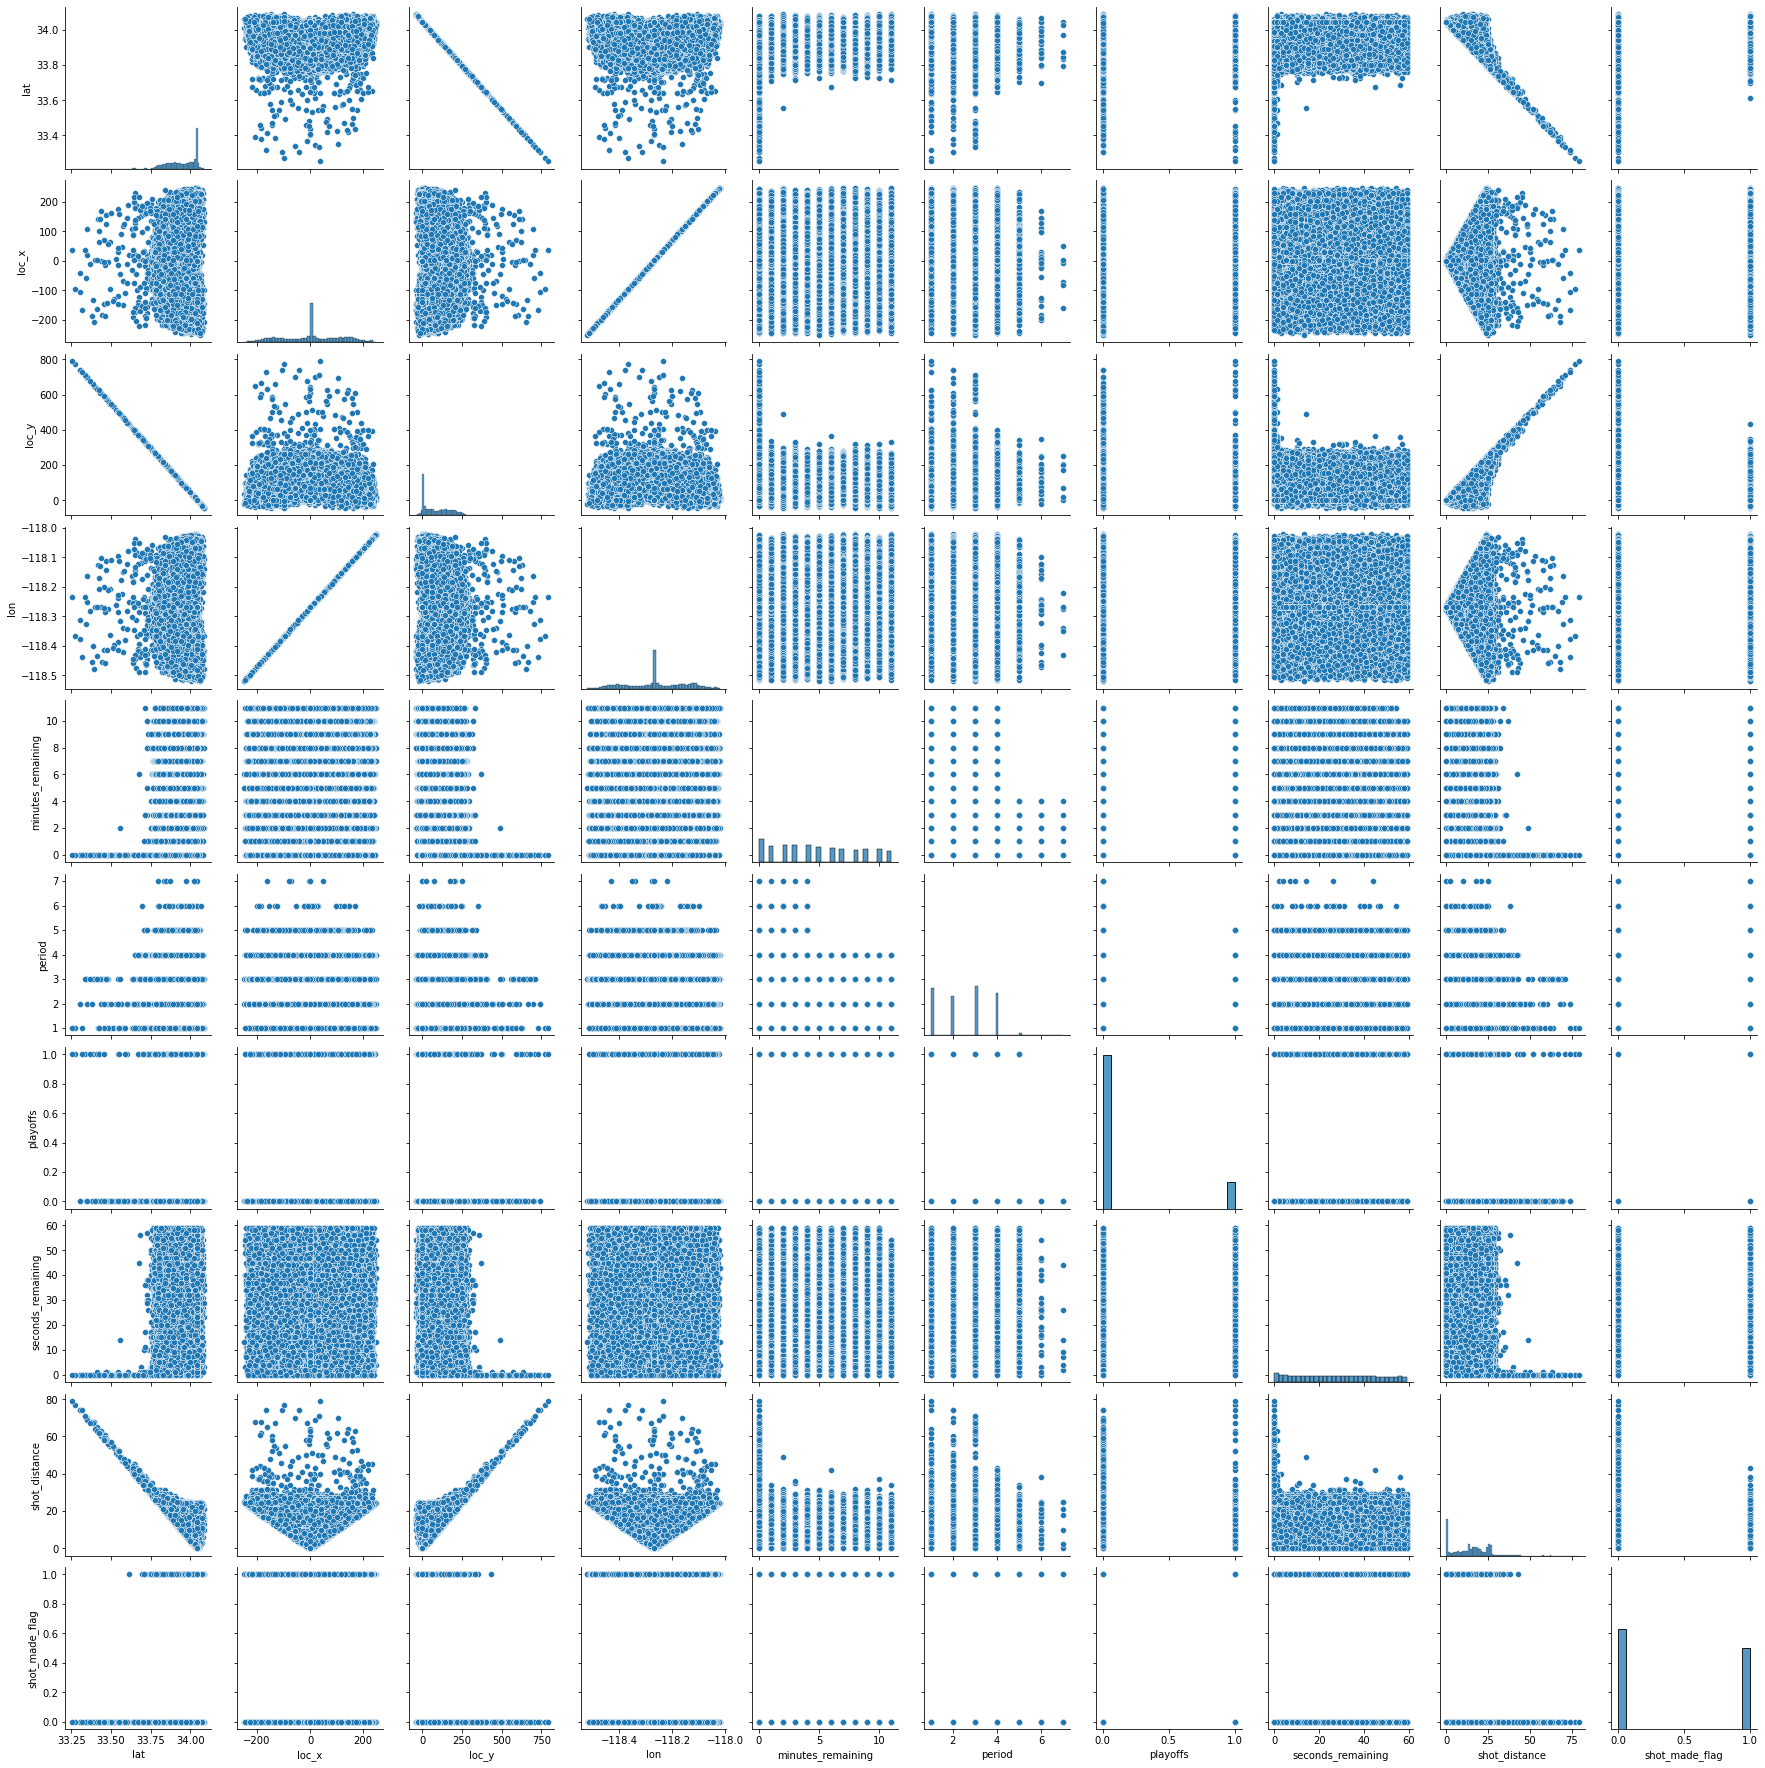

In [31]:
# Смотрим зависмость между переменными. Замечаем, что loc_x и lon, a также loc_y и lat имеют прямую зависимость. 

sns.pairplot(data2)

In [32]:
# Отбросим одну из пар переменных (lon, lat)

data2= data1[['action_type','combined_shot_type',
       'loc_x', 'loc_y', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       ]]

In [34]:
# Преобразуем часть данных через LabelEncoder
le = LabelEncoder()

In [43]:
le.fit_transform([ '1996-97' ,'1997-98', '1998-99' ,'1999-00','2000-01', '2001-02' ,'2002-03' ,'2003-04',
                   '2004-05', '2005-06' ,'2006-07','2007-08' ,'2008-09', '2009-10', '2010-11' ,'2011-12',
                   '2012-13' ,'2013-14', '2014-15', '2015-16'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [36]:
data3 = data2

In [44]:
data3['season'] = le.transform(data3['season'] )

D:\DS\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
le.fit_transform(['2PT Field Goal', '3PT Field Goal'])

array([0, 1], dtype=int64)

In [48]:
data3['shot_type'] = le.transform(data3['shot_type'] )

D:\DS\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
le.fit_transform(['Less Than 8 ft.','8-16 ft.', '16-24 ft.'  ,'24+ ft.', 'Back Court Shot'])
data3['shot_zone_range'] = le.transform(data3['shot_zone_range'] )

D:\DS\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
data4 = data3

In [54]:
# Применяем One-Hot Encoding к категориальным переменным
data4 = pd.get_dummies(data4, columns = [ 'action_type','combined_shot_type', 'shot_zone_area', 'shot_zone_basic'] )

In [55]:
# Генерируем новые фичи

data4['total_sec_remain'] = data4['seconds_remaining'] + 60*data4['minutes_remaining'] 
data4['dist2'] = (data['loc_x']**2 + data['loc_y']**2)**(1/2)

In [93]:
X = data4.drop(['shot_made_flag'], axis = 1)
y = data4['shot_made_flag']

In [95]:
# Стандартизируем переменные 

X1 = X

scaler = StandardScaler()

X1[['loc_x', 'loc_y', 'minutes_remaining', 'period', 'season', 'seconds_remaining', 'shot_distance',
              'shot_zone_range']] = scaler.fit_transform(X1[['loc_x', 'loc_y', 'minutes_remaining', 'period', 'season', 'seconds_remaining', 'shot_distance',
               'shot_zone_range']])
# scaled_values = scaler.transform(X1[['loc_x', 'loc_y', 'minutes_remaining', 'period', 'season', 'seconds_remaining', 'shot_distance',
#                'shot_zone_range']])
# X1[['loc_x', 'loc_y', 'minutes_remaining', 'period', 'season', 'seconds_remaining', 'shot_distance',
#               'shot_zone_range']] = pd.DataFrame(data=scaled_values, columns=['loc_x', 'loc_y', 'minutes_remaining', 'period', 'season', 'seconds_remaining', 'shot_distance',
#                'shot_zone_range'
#        ])

In [97]:
# делим на данные на тренировочные и тестовые

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state = 31)

In [98]:
# Обучаем модели

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

D:\DS\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [259]:
lass = linear_model.Lasso(alpha=0.05)
lass.fit(X_train,y_train)

Lasso(alpha=0.05)

In [102]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train,y_train)

RidgeClassifier()

In [231]:
coeff = np.append(np.array([X_train.columns]), np.array([log_reg.coef_[0],lass.coef_, rdg.coef_[0]]), axis = 0)

In [246]:
d= pd.DataFrame(data = coeff.T, columns = ['coeff','log', 'lass', 'ridge'])

In [263]:
# сравниваем коэффициенты полученные разными моделями. Можно заметить, что Lasso модель оставила только две переменные, 
# которые мы создали дополнительнор ранее

d.sort_values(by='lass', ascending=False)

,coeff,log,lass,ridge
84,total_sec_remain,0.001342,0.000024,0.000086
0,loc_x,-0.014779,0.0,-0.017305
54,action_type_Running Slam Dunk Shot,0.00199,0.0,0.211506
62,action_type_Turnaround Finger Roll Shot,0.001877,0.0,0.259684
61,action_type_Turnaround Fadeaway shot,0.046605,0.0,-0.121755
...,...,...,...,...
27,action_type_Finger Roll Layup Shot,0.01588,0.0,0.131752
26,action_type_Fadeaway Jump Shot,0.043995,0.0,-0.1596
25,action_type_Fadeaway Bank shot,0.025239,0.0,0.384944
24,action_type_Dunk Shot,0.0473,0.0,-0.196199


In [275]:
# Сравниваем точность моделей с помощью ROC AUC

print('Logistic regression: ', roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
print('Lasso: ',roc_auc_score(y_test, lass.predict(X_test)))
print('Ridge: ',roc_auc_score(y_test, rdg.predict(X_test)))

Logistic regression:  0.6830740730964058
Lasso:  0.6137447566491975
Ridge:  0.6576926698404802


In [281]:
# Строим PCA на подготовленных переменных

pca = PCA(n_components=86)

In [291]:
# PCA показывает, что два главных компонента объясняют большую часть целевой переменной (82% и 17% соотвественно)

pca.explained_variance_ratio_

array([8.28492837e-01, 1.71380604e-01, 2.17966758e-05, 1.93895240e-05,
       1.91746002e-05, 1.83966056e-05, 1.43867841e-05, 6.31364557e-06,
       5.56080570e-06, 2.71065249e-06, 2.57563329e-06, 2.35591827e-06,
       2.17897473e-06, 1.68019057e-06, 1.61847908e-06, 1.35684717e-06,
       9.53173046e-07, 7.41287610e-07, 6.52711489e-07, 5.71319290e-07,
       3.70915598e-07, 3.63268266e-07, 3.26229164e-07, 3.05970680e-07,
       2.79488046e-07, 2.76565496e-07, 2.31576299e-07, 2.22541415e-07,
       2.19819236e-07, 1.73066453e-07, 1.42850347e-07, 1.32776843e-07,
       1.12318479e-07, 9.70005859e-08, 9.05967245e-08, 8.53908556e-08,
       7.11793143e-08, 5.75335245e-08, 5.22380046e-08, 5.00100445e-08,
       4.55480176e-08, 4.38423612e-08, 3.94209718e-08, 3.64298383e-08,
       3.51762189e-08, 3.31360643e-08, 2.33281002e-08, 2.30196364e-08,
       1.98281981e-08, 1.83552364e-08, 1.74948201e-08, 1.60166797e-08,
       1.58338146e-08, 1.47111749e-08, 1.25893249e-08, 1.18642788e-08,
      